In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# For training on GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Print folders in the dataset

In [3]:
!ls dataset

cardboard  glass  metal  organtic  paper  plastic  trash


# Define dataset

In [4]:
image_size = (384, 512)

batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2999 files belonging to 7 classes.
Using 2400 files for training.
Found 2999 files belonging to 7 classes.
Using 599 files for validation.


Print some of the images in the dataset

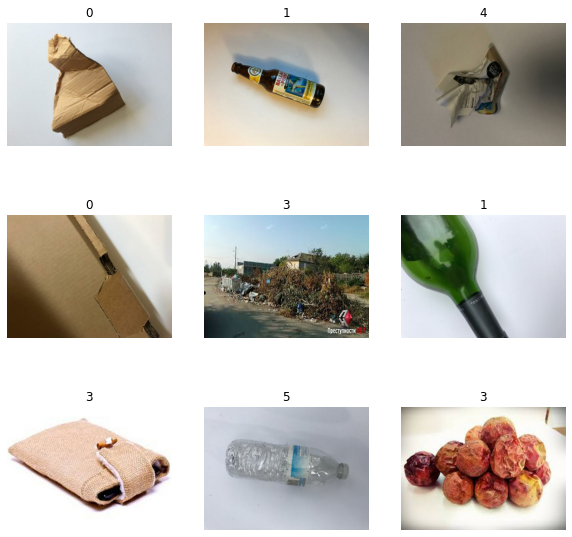

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [7]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

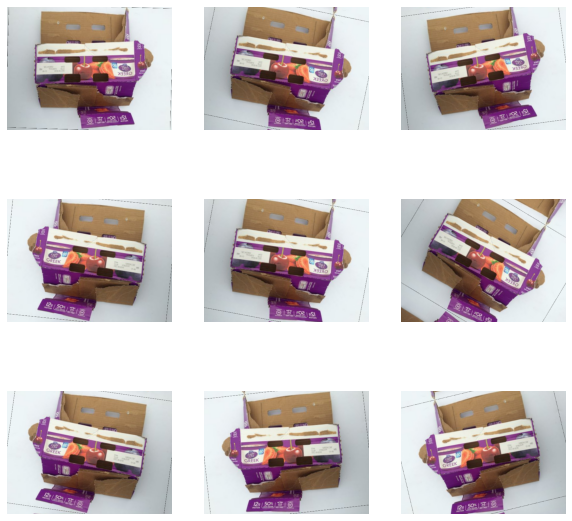

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(include_top=False, input_shape=image_size + (3,), classes=7)

# Freeze the base_model
base_model.trainable = False

inputs = tf.keras.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(7, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

58892288/58889256 [==============================] - 4s 0us/step


In [12]:
# Make sure we are using the GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


Train the model

In [13]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 384, 512, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 384, 512, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 384, 512, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 12, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

Plot the training results

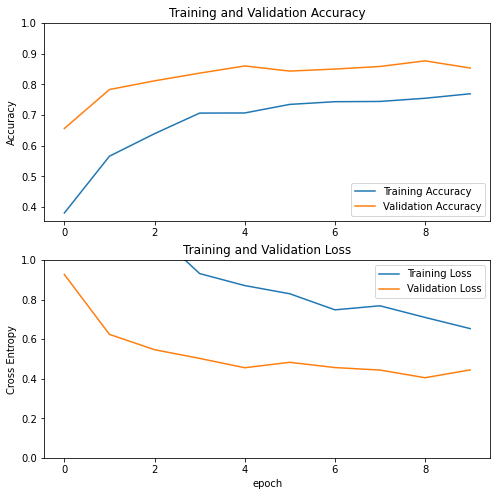

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [15]:
# Install opencv for image resizing
import sys
!{sys.executable} -m pip install opencv-python

     |████████████████████████████████| 49.5 MB 6.0 MB/s eta 0:00:011
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import cv2

def plot(class_names, prediction, true_label, predicted_label, img):
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(prediction)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],100*np.max(prediction),class_names[true_label]),color=color)
    plt.subplot(1,2,2)
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(class_names, prediction, color="#777777")
    plt.ylim([0, 1])
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


Test the model by loading images

In [ ]:
CLASS_NAMES = ['cardboard', 'glass', 'metal', 'organtic', 'paper', 'plastic', 'trash']

def main():
     print(f"--Load Model--")
     model = tf.keras.models.load_model("save_at_10.h5")
     print(f"--Load Image--")
     img = plt.imread("phone_image.jpg")
     img = cv2.resize(img, (512, 384))
     print(f"--Predict as Class--")
     predict(model, CLASS_NAMES, img, 4)

def predict(model, class_names, img, true_label):
    img = np.array([img])
    prediction = model.predict(tf.cast(img, tf.float32))[0]
    #Determine what the predicted label is
    predicted_label = np.argmax(prediction)
    print(class_names[predicted_label])
    plot(class_names, prediction, true_label, predicted_label, img[0])
    plt.show()

main()
